In [1]:
import pandas as pd
import os


In [2]:
events_file = pd.read_csv(os.path.join(os.path.dirname("__file__"), "data_eventos.csv"), encoding='utf-8', sep=",")

● Procesamiento de Top 10 de palabras que se encuentran primero de todas las partidas.

Primero chequea si el csv esta vacio (.empty considera vacio tambien si solo esta en encabezado). Si no lo esta:
indices contendra los indices de la columna siguiente a la que contiene un evento llamado "inicio_partida"
indices corregidos compara los indices tomados y chequea si son respuestas (para evitar contar el caso en que el siguiente evento luego del inicio de una partida sea una finalizacion) 
palabras es un Series que contiene las respuestas de dichas columnas, y primeras_palabras es palabras sumando sus valores, ordenados de mayor a menor y tomando las 10 primeras

In [3]:

if events_file.empty:
    print("No hay partidas registradas")
else:
    indices = (events_file[events_file["evento"] == "inicio_partida"].index)+1
    indices_corregidos = (events_file["evento"][indices] == "intento").index

    palabras = events_file["respuesta"][indices_corregidos]
    primeras_palabras = palabras.sort_values().value_counts()[:10]
    print(f"Top 10 primeras palabras de todas las partidas:\n\n{primeras_palabras}")

    

KeyError: '[204] not in index'

● Gráfico que muestre el porcentaje de partidas por estado (fin, cancelada, error, timeout). También debe tener en cuenta las partidas que se terminaron inesperadamente o de forma repentina (partidas sin evento de fin)

Si el csv no esta vacio: El bloque for itera sobre el dataframe y analiza los siguientes casos: se halla el inicio y el fin de la partida, se hallar dos inicios sin un fin entre ellos. En el ultimo caso, se incrementa la variable que cuenta las partidas sin fin (no_fin). El ultimo if analiza si el ultimo evento es un fin, para determinar si la ultima partida registrada es el caso.
Luego cuenta los eventos de las rondas (sin tomar las correctas). Por ultimo, convierte no_fin a Series y lo agrega al Series porc_por_estado para armar el grafico

C:\Users\ivomi\AppData\Local\Temp\ipykernel_14084\2317288099.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  porc_por_estado = cant_estados.append(cant_no_fin)


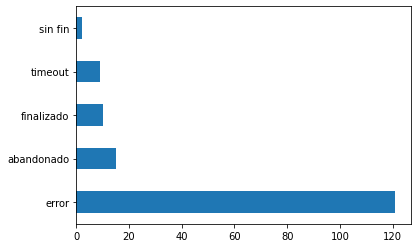

In [4]:
if events_file.empty:
    print("No hay partidas registradas")
else:
    no_fin = 0
    hay_inicio = False
    for col_nombre, col_valores in events_file["evento"].iteritems():                
        if(col_valores == "inicio_partida") and (not hay_inicio):
            hay_inicio = True
        elif(col_valores == "inicio_partida") and (hay_inicio):
            hay_inicio = False
            no_fin += 1
        elif(col_valores == "fin"):
            hay_inicio = False
    if((events_file["evento"][len(events_file)-1] != "fin")and(hay_inicio)):
        no_fin += 1

    cant_estados = events_file["estado"][events_file["estado"] != "ok"].value_counts()
    cant_no_fin = pd.Series(no_fin, index=["sin fin"])
    porc_por_estado = cant_estados.append(cant_no_fin)

    porc_por_estado.plot(kind="barh")

● Gráfico que muestre el porcentaje de partidas finalizadas según género.

Si el csv no esta vacio: Abre el archivo de perfiles, luego incrementa aquel valor del diccionario correspondiente al genero obtenido del usuario correspondiente al evento, por cada completamiento de partida. Por ultimo conviente la variable en Series para armar el grafico.

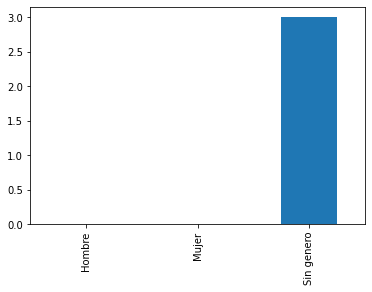

In [5]:
if events_file.empty:
    print("No hay partidas registradas")
else:
    perfiles_data = pd.read_json("data.json")

    finalizadas_generos = {"Hombre": 0, "Mujer": 0, "Sin genero": 0}
    usuarios_fin = (events_file[events_file["estado"] == "finalizado"]["usuarie"]).unique()
    for usuario in usuarios_fin:
        finalizadas_generos[perfiles_data[usuario]["genero"].capitalize()] += 1
    finalizadas_generos = pd.Series(finalizadas_generos)
    finalizadas_generos.plot(kind="bar")
        

● Gráfico que muestre el porcentaje de partidas finalizadas según nivel.

Si el csv no está vacio: cuenta los niveles de aquellas partidas completadas y lo convierte en un grafico

In [ ]:
if events_file.empty:
    print("No hay partidas registradas")
else:
    finalizadas = events_file[events_file["estado"] == "finalizado"]["nivel"].value_counts()
    finalizadas.plot(kind="bar")

Tiempo de la respuesta exitosa más rápida.

Toma el tiempo de las respuestas correctas y de sus eventos anteriores y los resta. Luego se queda con el menor (si hubo alguna respuesta exitosa)

In [ ]:
mas_rapida = 9999
tiempo_act = events_file[events_file["estado"] == "ok"]["timestamp"]
tiempo_ant = events_file["timestamp"][(events_file[events_file["estado"] == "ok"].index)-1]
t = list(map(lambda x, y: x - y, tiempo_act, tiempo_ant))
if len(t) < 1:
    print("No se han encontrado respuestas exitosas")
else:
    mas_rapida = min(t)
    print(f"Tiempo de la respuesta exitosa más rápida: {round(mas_rapida, 2)} segundos")

● Promedio de tiempo de respuesta para respuestas exitosas.

Toma variables calculadas anteriormente y realiza calculo de promedio (si hubo alguna respuesta exitosa)

In [ ]:
if len(t) > 0:
    prom_rtas = sum(t) / len(t)
    print(f"Promedio de tiempo de respuesta para respuestas exitosas: {round(prom_rtas, 2)} segundos")
else:
    print("No se puede realizar el promedio si no existen respuestas exitosas")

● Promedio de tiempo de partida general.

Itera sobre todo el dataframe cargando la variable indice_inicio cuando halla un evento de inicio y cuando halla un evento de fin resta el tiempo de ese evento con el correspondiente al inicio. Tambien suma la cantidad de partidas. En el caso en que una partida no tiene evento fin, se vuelve a tomar el indice cuando halla otro inicio, por lo que no es problema. Luego calcula el promedio, y si no hay partidas levanta una excepcion

In [ ]:
suma_tiempo = 0
partidas = 0
hay_inicio = False
indice_inicio = 0
for index, values in events_file.iterrows():
    if values["evento"] == "inicio_partida": 
        indice_inicio = index
        hay_inicio = True

    if values["evento"] == "fin":
        suma_tiempo += values["timestamp"] - events_file["timestamp"][indice_inicio]
        partidas += 1
try:
    promedio = suma_tiempo / partidas
    print(f"Promedio de tiempo de partida general: {round(promedio, 2)} segundos")
except ZeroDivisionError:
    print("No hay partidas registradas")

● Porcentaje de aciertos por usuarie.

Si hay usuarios registrados: se toman los usuarios y por cada uno se toma el total de respuestas (intentos) y el total de aciertos (estado = ok). Luego se calcula el promedio y se agrega a un Series tomando como indice el nombre de usuario.

In [ ]:
usuarios = events_file["usuarie"].unique()
if len(usuarios) < 1:
    print("No hay usuarios registrados")
else:
    aciertos_usuario = pd.Series()
    for u in usuarios:
        total = len(events_file[events_file["usuarie"] == u][events_file["evento"] == "intento"])
        aciertos = len((events_file[events_file["usuarie"] == u][events_file["estado"] == "ok"]))
        if(total > 0):
            porc_aciertos = pd.Series(f"{aciertos / total} %", index=[u])
        else:
            porc_aciertos = pd.Series(f"{aciertos} %", index=[u])
        aciertos_usuario = aciertos_usuario.append(porc_aciertos)
    print(f"Porcentaje de aciertos por usuarie: \n\n{aciertos_usuario}")

● Cantidad de tarjetas para las que el usuarie no dió respuesta (timeout).

Se toma la cantidad de columnas cuyo estado es "timeout"

In [ ]:
cant_timeouts = len(events_file[events_file["estado"] == "timeout"])
print(f"Cantidad de rondas sin respuesta totales: {cant_timeouts}")

● Cantidad de tarjetas en las que el usuarie dió una respuesta errónea.

Se toma la cantidad de columnas cuyo estado es "error"

In [ ]:
cant_erroneas = len(events_file[events_file["estado"] == "error"])
print(f"Cantidad de respuestas erroneas totales: {cant_erroneas}")